# Polarity Detection

In [1]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from IPython.display import Markdown as md
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import metrics
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [2]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

## Read Data

In [4]:
df = pd.read_csv('.Data Files/full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [5]:
# Extracting the predict values and counting number of negative and positive
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

## Split and scale dataset

In [6]:
columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

## Basic Model Function

In [7]:
# Function to make models
def DNN_model(num_neurons):
    model = Sequential()
    model.add(keras.Input(shape=(77,)))
    model.add(Dense(num_neurons, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [8]:
# Variable used to implement early stopping, used in callback of model.fit
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

## Question 1 

### a) Use the training dataset to train the model for 100 epochs. Implement early stopping with patience of 3

In [9]:
model = DNN_model(128)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, 
                    epochs=100, batch_size=256, 
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[es] #using early stopping as a callback 
                   )

Epoch 1/100
499/499 [==============================] - 9s 13ms/step - loss: 0.6899 - accuracy: 0.5360 - val_loss: 0.6849 - val_accuracy: 0.5514
Epoch 2/100
499/499 [==============================] - 6s 11ms/step - loss: 0.6833 - accuracy: 0.5529 - val_loss: 0.6816 - val_accuracy: 0.5552
Epoch 3/100
499/499 [==============================] - 6s 12ms/step - loss: 0.6800 - accuracy: 0.5585 - val_loss: 0.6802 - val_accuracy: 0.5595
Epoch 4/100
499/499 [==============================] - 6s 12ms/step - loss: 0.6777 - accuracy: 0.5663 - val_loss: 0.6768 - val_accuracy: 0.5671
Epoch 5/100
499/499 [==============================] - 6s 12ms/step - loss: 0.6746 - accuracy: 0.5701 - val_loss: 0.6744 - val_accuracy: 0.5743
Epoch 6/100
499/499 [==============================] - 7s 14ms/step - loss: 0.6713 - accuracy: 0.5773 - val_loss: 0.6716 - val_accuracy: 0.5776
Epoch 7/100
499/499 [==============================] - 7s 15ms/step - loss: 0.6676 - accuracy: 0.5849 - val_loss: 0.6674 - val_accuracy:

### b) Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

Text(0, 0.5, 'Accuracy')

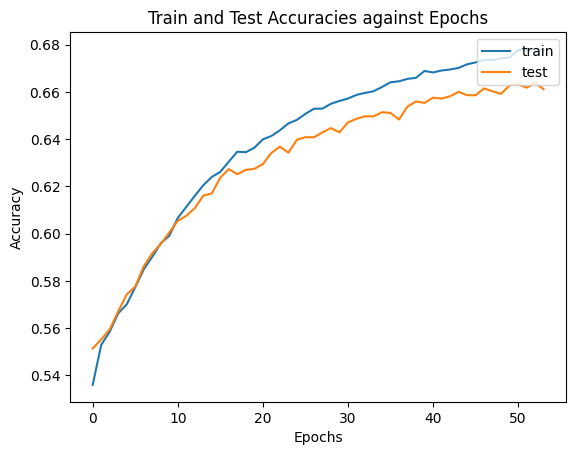

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train and Test Accuracies against Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Comment on the Accuracy plot

The model training stops at epoch ~60 and both the train and test accuracies continously increase as the number of epochs keep increasing.

At epoch ~15 the accuracy of the test data starts to increase slower compared to the accuracy of the train data. The slope of the test accuracy seems to stabilise at epoch ~60 therefore we can conclude that our early stopping was right to stop at epoch 61 which is ~60.

Text(0, 0.5, 'Loss')

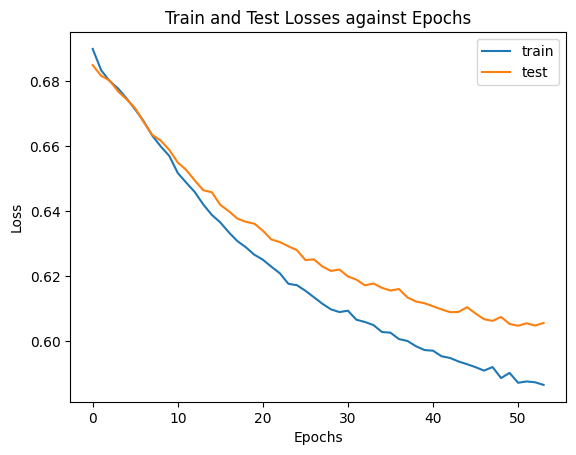

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Test Losses against Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Comment on the Loss plot

The model training stops at epoch ~60 and both the train and test losses continously decrease as the number of epochs keep increasing.

At epoch ~15 the loss of the test data starts to decrease slower compared to the loss of the train data. The slope of the test loss seems to stabilise at epoch ~60 therefore we can conclude that our early stopping was right to stop at epoch 61 which is ~60.

### Explain the use of early stopping in this question

**Early Stopping** - Early stopping is an optimization technique used to reduce overfitting without compromising on model accuracy. The main idea behind early stopping is to stop training before a model starts to overfit. Stop training when a monitored metric has stopped improving.

Since we see our convergence of 'val_loss' around 61 after using early stopping it is good to stop the training at epoch 61 (based on early stopping) to avoid overfitting of the train data onto our model.

We want to stop training the neural network when there has not been any improvement in the monitored metric - 'val_loss' for a patience level of 3 (3 epochs where there has been no improvement in the metric)



## Question 2 

In [12]:
from sklearn.model_selection import KFold
import numpy as np

In [13]:
import time

# Custom callback to get time taken per epoch and accuracy from each epoch
class TimeAccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.accuracies = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        self.accuracies.append(logs['val_accuracy'])
        
        
callback = TimeAccuracyHistory()

### a) Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}

In [13]:
# Limiting search space to the specified batch sizes
batch_sizes = [128, 256, 512, 1024]
num_folds = 5

In [14]:
# running k-fold cross validation with k=5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Variables to store the mean accuracy on the final epoch for different batch sizes and 
# time taken to train the network on the last epoch against different batch sizes 
mean_accuracy = []
mean_time = []

standard_scaler = preprocessing.StandardScaler()
fitted_scaler = standard_scaler.fit(X_train)

for i in range(len(batch_sizes)): 
    batch_size = batch_sizes[i]
    
    print('Running for Batch Size:', batch_size, ' -------------------------')
    cnt = 1
    accuracies = []
    times = []
    for train, test in kfold.split(X_train, y_train):

        x_train, Y_train = X_train.iloc[train], y_train[train]
        x_test, Y_test = X_train.iloc[test], y_train[test]
    
        x_train_scaled = fitted_scaler.transform(x_train)
        x_test_scaled = fitted_scaler.transform(x_test)
        
        print('Running for fold : ', cnt, ' -------------------------------')
        cnt+=1
        model = DNN_model(128)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])

        history = model.fit(x_train_scaled, Y_train, 
                        epochs=100, batch_size=batch_size, 
                        validation_data=(x_test_scaled, Y_test), 
                        callbacks=[es, callback]) # using custom callback 'callback' to get times and accuracies of each epoch
        
        last = len(callback.times) # Finding the length so we only take the last value (last-1)
        times.append(callback.times[last-1])
        accuracies.append(callback.accuracies[last-1])
    mean_accuracy.append(sum(accuracies)/len(accuracies))
    mean_time.append(times)

Running for Batch Size: 128  -------------------------
Running for fold :  1  -------------------------------
Epoch 1/100
798/798 [==============================] - 2s 2ms/step - loss: 0.6900 - accuracy: 0.5365 - val_loss: 0.6843 - val_accuracy: 0.5484
Epoch 2/100
798/798 [==============================] - 1s 2ms/step - loss: 0.6836 - accuracy: 0.5525 - val_loss: 0.6819 - val_accuracy: 0.5510
Epoch 3/100
798/798 [==============================] - 1s 2ms/step - loss: 0.6809 - accuracy: 0.5590 - val_loss: 0.6812 - val_accuracy: 0.5592
Epoch 4/100
798/798 [==============================] - 1s 2ms/step - loss: 0.6781 - accuracy: 0.5645 - val_loss: 0.6782 - val_accuracy: 0.5594
Epoch 5/100
798/798 [==============================] - 1s 2ms/step - loss: 0.6746 - accuracy: 0.5698 - val_loss: 0.6768 - val_accuracy: 0.5626
Epoch 6/100
798/798 [==============================] - 1s 2ms/step - loss: 0.6716 - accuracy: 0.5754 - val_loss: 0.6730 - val_accuracy: 0.5640
Epoch 7/100
798/798 [===========

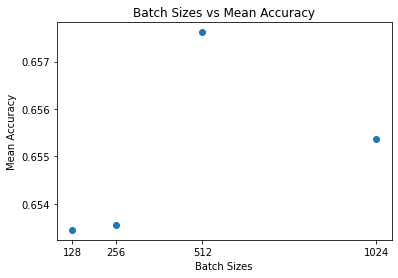

In [15]:
plt.scatter(batch_sizes, mean_accuracy)
plt.title('Batch Sizes vs Mean Accuracy')
plt.xticks(batch_sizes)
plt.xlabel('Batch Sizes')
plt.ylabel('Mean Accuracy')
plt.show()

### b)  Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [16]:
table = pd.DataFrame(mean_time, batch_sizes)
table.columns =['1st Fold', '2nd Fold', '3rd Fold', '4th Fold', '5th Fold']
table['mean'] = table.mean(axis=1)

In [17]:
# Create a table of time taken to train the network on the last epoch against different batch sizes
table

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold,mean
128,1.439656,1.424739,1.438219,1.431337,1.442264,1.435243
256,0.924828,0.938665,0.942044,0.914780,0.909070,0.925878
512,0.653512,0.629885,0.692064,0.640194,0.627295,0.648590
1024,0.450288,0.468776,0.453516,0.474351,0.460667,0.461520


### c) Select the optimal batch size and state a reason for your selection.

In [18]:
optimal_batch_size = batch_sizes[mean_accuracy.index(max(mean_accuracy))]
md(f'Select batch size = **{optimal_batch_size}** since the mean cross-validation accuracy is the highest. If the accuracy was similar to another batch size with lower time taken to train the model we could take the one with lower time but since there is a large difference in the accuracies we choose batch size = **{optimal_batch_size}**')

Select batch size = **512** since the mean cross-validation accuracy is the highest. If the accuracy was similar to another batch size with lower time taken to train the model we could take the one with lower time but since there is a large difference in the accuracies we choose batch size = **512**

### d) What happens when batch size increases, and why does it happen?

When the batch size increases, large gradient steps are taken while training the model for the given number of samples.

With an **increase in the batch size** - 

1. The rate with which the loss reduces decreases
2. The amount of time per epoch while training the model is lower
3. The ability of the model to generalize the data reduces

Looking at our table for time taken to train the network on the last epoch against different batch sizes we can see that the time decreases as our batch size becomes larger.

It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize the data.

When the batch size is small we assume that the model might be getting overfitted on the training data. We see that the accuracy decreases with an increase in batch size from 512 to 1024 since the model loses the ability to generalize the data well with bigger batch sizes due to the larger steps taken during gradient descent

### e) Plot the train and test accuracies against epochs for the optimal batch size in a line plot. 

In [19]:
model = DNN_model(128)
model.compile()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, 
                epochs=100, batch_size=optimal_batch_size, 
                validation_data=(X_test_scaled, y_test), 
                callbacks=[es])

Epoch 1/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6912 - accuracy: 0.5339 - val_loss: 0.6853 - val_accuracy: 0.5496
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6844 - accuracy: 0.5508 - val_loss: 0.6824 - val_accuracy: 0.5552
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6814 - accuracy: 0.5593 - val_loss: 0.6812 - val_accuracy: 0.5608
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6788 - accuracy: 0.5633 - val_loss: 0.6773 - val_accuracy: 0.5661
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6762 - accuracy: 0.5699 - val_loss: 0.6744 - val_accuracy: 0.5727
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6730 - accuracy: 0.5771 - val_loss: 0.6728 - val_accuracy: 0.5766
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6706 - accuracy: 0.5795 - val_loss: 0.6695 - val_accuracy: 0.5821

Text(0, 0.5, 'Accuracy')

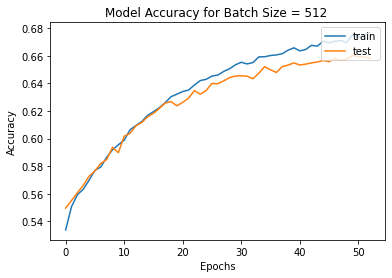

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Model Accuracy for Batch Size = {optimal_batch_size} ')
plt.legend(['train', 'test'], loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Question 3 

### a) Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}

In [21]:
# Limiting search space to specified number of neurons
num_neurons = [64, 128, 256]
num_folds = 5

In [22]:
# running k-fold cross validation with k=5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Variables to store the mean accuracy on the final epoch for different batch sizes and 
# time taken to train the network on the last epoch against different batch sizes 
mean_accuracy = []
mean_time = []

standard_scaler = preprocessing.StandardScaler()
fitted_scaler = standard_scaler.fit(X_train)

for i in range(len(num_neurons)):
    num_neuron = num_neurons[i]
    print('Running for Number of Neurons:', num_neuron, ' --------------')
    cnt = 1
    accuracies = []
    times = []
    for train, test in kfold.split(X_train, y_train):
        
        x_train, Y_train = X_train.iloc[train], y_train[train]
        x_test, Y_test = X_train.iloc[test], y_train[test]
    
        x_train_scaled = fitted_scaler.transform(x_train)
        x_test_scaled = fitted_scaler.transform(x_test)
        
        print('Running for fold : ', cnt, ' -------------------------------')
        cnt+=1
        model = DNN_model(num_neuron)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])

        history = model.fit(x_train_scaled, Y_train, 
                        epochs=100, batch_size=optimal_batch_size, 
                        validation_data=(x_test_scaled, Y_test), 
                        callbacks=[es, callback]) # using custom callback 'callback' to get times and accuracies of each epoch
        
        last = len(callback.times) # Finding the length so we only take the last value (last-1)
        times.append(callback.times[-1])
        accuracies.append(callback.accuracies[-1])
    mean_accuracy.append(sum(accuracies)/len(accuracies))
    mean_time.append(times)

Running for Number of Neurons: 64  --------------
Running for fold :  1  -------------------------------
Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.5279 - val_loss: 0.6864 - val_accuracy: 0.5449
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6860 - accuracy: 0.5467 - val_loss: 0.6846 - val_accuracy: 0.5487
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6837 - accuracy: 0.5521 - val_loss: 0.6826 - val_accuracy: 0.5524
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6816 - accuracy: 0.5578 - val_loss: 0.6818 - val_accuracy: 0.5526
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6806 - accuracy: 0.5596 - val_loss: 0.6803 - val_accuracy: 0.5583
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6782 - accuracy: 0.5661 - val_loss: 0.6782 - val_accuracy: 0.5613
Epoch 7/100
200/200 [================

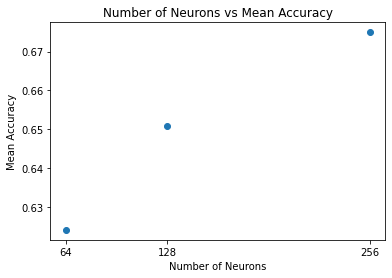

In [23]:
plt.scatter(num_neurons,mean_accuracy)
plt.title('Number of Neurons vs Mean Accuracy')
plt.xticks(num_neurons)
plt.xlabel('Number of Neurons')
plt.ylabel('Mean Accuracy')
plt.show()

### b) Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [24]:
optimal_num_neuron = num_neurons[mean_accuracy.index(max(mean_accuracy))]
md(f'Select number of neurons = **{optimal_num_neuron}** since the mean cross-validation accuracy is the highest.')

Select number of neurons = **256** since the mean cross-validation accuracy is the highest.

### c) Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

In [25]:
# Saving our model with optimal values as best_model
best_model = DNN_model(optimal_num_neuron)
best_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = best_model.fit(X_train_scaled, y_train, 
                epochs=100, batch_size=optimal_batch_size, 
                validation_data=(X_test_scaled, y_test), 
                callbacks=[es])

Epoch 1/100
250/250 [==============================] - 2s 5ms/step - loss: 0.6903 - accuracy: 0.5349 - val_loss: 0.6846 - val_accuracy: 0.5494
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6831 - accuracy: 0.5531 - val_loss: 0.6810 - val_accuracy: 0.5569
Epoch 3/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6791 - accuracy: 0.5616 - val_loss: 0.6792 - val_accuracy: 0.5622
Epoch 4/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6760 - accuracy: 0.5687 - val_loss: 0.6743 - val_accuracy: 0.5728
Epoch 5/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6719 - accuracy: 0.5781 - val_loss: 0.6707 - val_accuracy: 0.5794
Epoch 6/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6676 - accuracy: 0.5861 - val_loss: 0.6675 - val_accuracy: 0.5867
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6629 - accuracy: 0.5936 - val_loss: 0.6625 - val_accuracy: 0.5910

Text(0, 0.5, 'Accuracy')

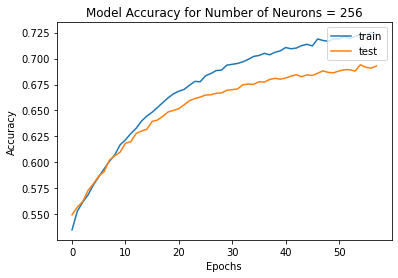

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Model Accuracy for Number of Neurons = {optimal_num_neuron}')
plt.legend(['train', 'test'], loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [27]:
# Reaffirming the best parameters of the model
print(optimal_batch_size)
print(optimal_num_neuron)

512
256


### d) How does dropouts work, and what is the purpose of dropouts?

**Dropout** is a technique where randomly selected neurons are ignored during training. They are “dropped out” randomly. This means that their contribution to the activation of downstream neurons is temporarily removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass.

**The purpose of dropouts** is to prevent the network from overfitting the data and  for better generalization of the data. It works by randomly selecting neurons to be ignored during the training phase.

### e) Besides early stopping and dropout, what is another approach that you could take to address overfitting in the model, and how does it work? Implement the approach.

Besides early stopping and dropout we can use either **L1 regularization (or lasso) or L2 regularization (or ridge).**

Regularization prevents overfitting by adding information to the model while training. It redistributes the weights evenly and removes extra weights from the selected features.

**L1 regularization** works by adding the penalty term to the cost function as a summation of the absolute value of the coefficients. L1 helps in both feature selection and regularization.

**L2 regularization** works by adding the penalty term to the cost function as a summation of the squared value of the coefficients. L2 distributes the coefficient value accross all features.


In [28]:
# Model without any overfitting reduction measures
def DNN_model_overfitting(num_neurons):
    model = Sequential()
    model.add(keras.Input(shape=(77,)))
    model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [29]:
model = DNN_model_overfitting(optimal_num_neuron)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, 
                    epochs=100, batch_size=optimal_batch_size, 
                    validation_data=(X_test_scaled, y_test) #using early stopping as a callback 
                   )

Epoch 1/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6829 - accuracy: 0.5547 - val_loss: 0.6774 - val_accuracy: 0.5663
Epoch 2/100
250/250 [==============================] - 1s 2ms/step - loss: 0.6692 - accuracy: 0.5844 - val_loss: 0.6715 - val_accuracy: 0.5794
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6529 - accuracy: 0.6079 - val_loss: 0.6614 - val_accuracy: 0.5945
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6336 - accuracy: 0.6343 - val_loss: 0.6510 - val_accuracy: 0.6131
Epoch 5/100
250/250 [==============================] - 1s 2ms/step - loss: 0.6119 - accuracy: 0.6566 - val_loss: 0.6408 - val_accuracy: 0.6267
Epoch 6/100
250/250 [==============================] - 1s 2ms/step - loss: 0.5900 - accuracy: 0.6771 - val_loss: 0.6300 - val_accuracy: 0.6391
Epoch 7/100
250/250 [==============================] - 1s 2ms/step - loss: 0.5691 - accuracy: 0.6968 - val_loss: 0.6276 - val_accuracy: 0.6473

Text(0, 0.5, 'Accuracy')

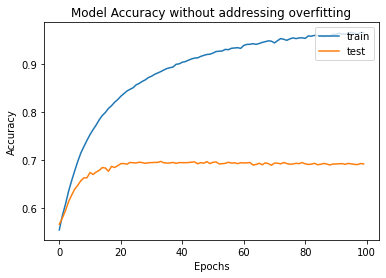

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy without addressing overfitting')
plt.legend(['train', 'test'], loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

From this plot we can see that when early stopping and dropouts are not used the model starts to overfit on the train data as there is a dip in the test accuracy at the end of 100 epochs. This dip is there in the test accuracy even though the train accuracy is continously increasing

This shows that our model is being overfitted on the training data since train accuracy keeps increasing while our test accuracy decreases slightly

In [31]:
def DNN_model_regularization(num_neurons):
    model = Sequential()
    model.add(keras.Input(shape=(77,)))
    model.add(Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [32]:
model = DNN_model_regularization(optimal_num_neuron)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, 
                    epochs=100, batch_size=optimal_batch_size, 
                    validation_data=(X_test_scaled, y_test) #using early stopping as a callback 
                   )

Epoch 1/100
250/250 [==============================] - 1s 3ms/step - loss: 1.4049 - accuracy: 0.5356 - val_loss: 0.6956 - val_accuracy: 0.5374
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6927 - accuracy: 0.5401 - val_loss: 0.6926 - val_accuracy: 0.5415
Epoch 3/100
250/250 [==============================] - 1s 2ms/step - loss: 0.6919 - accuracy: 0.5408 - val_loss: 0.6933 - val_accuracy: 0.5346
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6919 - accuracy: 0.5401 - val_loss: 0.6921 - val_accuracy: 0.5381
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6915 - accuracy: 0.5413 - val_loss: 0.6917 - val_accuracy: 0.5421
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6912 - accuracy: 0.5412 - val_loss: 0.6914 - val_accuracy: 0.5413
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6913 - accuracy: 0.5428 - val_loss: 0.6914 - val_accuracy: 0.5402

Text(0, 0.5, 'Accuracy')

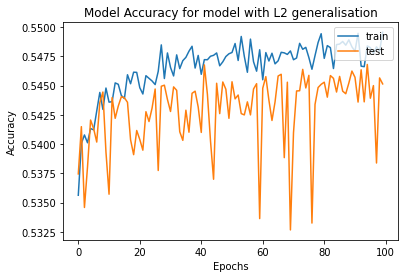

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy for model with L2 generalisation')
plt.legend(['train', 'test'], loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

From this plot we can see that our train and test accuracies are very similar even though the variance is high, ie, the test accuracy changes along with the train accuracy and it does not decrease as train accuracy increases.

Therefore we conclude from this plot that L2 regularization is a method of preventing overfitting.

## Question 4

### a) Record yourself with a wav file for 5 seconds, either in a positive or a negative manner. Preprocess the data using the provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.

**Recorded Files :**
1. record(2).wav

**Transformed files after using data_preprocess.ipynb :**
1. negative.csv

### b)  Do a model prediction on your sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons.

In [34]:
new_data = pd.read_csv('negative.csv')
new_data = new_data.drop(columns=['filename'])
new_data

,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,112.347147,546,78.0,0.502497,0.097981,0.460442,0.090139,0.248548,0.021557,0.047959,...,-8.937523,108.85267,-5.612281,65.80591,-4.388521,82.35793,-8.19348,87.39054,-5.40608,61.64888


In [35]:
# Appending to X_test so that we can effectively scale the data for our test sample
X_test = X_test.append(new_data, ignore_index=True)

# Scaling the data
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# Extracting only our test sample
final_test = X_test_scaled[-1:]

# Using our best_model to predict on my voice
predict = best_model.predict(final_test)

1/1 [==============================] - 0s 83ms/step


In [36]:
# Predicting with a threshold of 0.5
prediction = ''
if predict[0][0]>0.5:
    print(predict[0][0])
    print('Positive')
    prediction = 'Positive'
else:
    print(predict[0][0])
    print('Negative')
    prediction = 'Negative'

0.45038286
Negative


In [37]:
md(f'Therefore we conclude that my audio sample was **{prediction}**')

Therefore we conclude that my audio sample was **Negative**

### c) Find the most important features on the model prediction for your test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.

In [16]:
import shap

shap.initjs()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


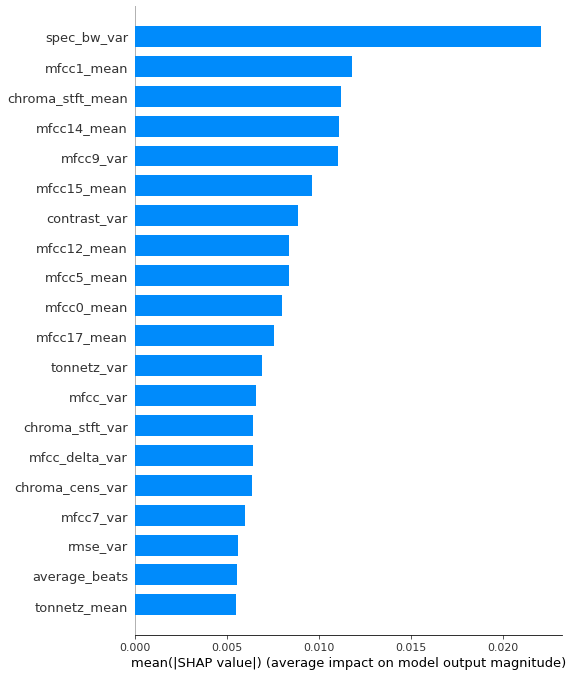

In [39]:
inds = np.random.choice(X_train_scaled.shape[0], 10, replace=False)

explainer = shap.DeepExplainer(best_model, X_train_scaled[inds,:])
shap_values = explainer.shap_values(final_test)

# Feature importance
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = new_data.columns)

The SHAP summary plot plots a bar plot with the absolute SHAP values. Features that have a lage absolute SHAP value are important in predicting our new sample.

The plot shows the feature importance while predicting the sentiment of our voice recording and which features have the most importance in decreasing order of importance.

In [40]:
# Feature importance with a force plot
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = new_data.columns)

**Shaap Force Plot**
- The features that are important while predicting on our test sample are shown in red and blue
- The features in red cause an increase in the model score and the size of the feature shows the magnitude of its effect
- The features in blue cause a decrease in the model score and the size of the feature shows the magnitude of its effect
- Features that have a higher impact are located closer to the division boundary

Therefore the **most important features** on the model prediction for my test sample using SHAP is **spec_bw_var**  

# Conclusion

- What are some limitations of the current approach (using FFNs to model such engineered features)?

Despite the advantages of using Feed Forward Networks (Deep Neural Networks) there are also some limitation that come with using these models. The most notable issue of all is that these networks require large amounts of data in order to be trained properly and function properly. It also takes a long time to be trained.

- Out of the parameters that were tuned, which was most impactful in terms of improving the model performance and what could be some reasons for that? 

Out of the parameters that were tuned the most impactful in terms of improving the model performance was the number of neurons in the hidden layer. From the accuracy graphs plotted we can see that the difference in accuracy is much greater when we change the number of neurons in the first hidden layer. The increase in accuracy does not differ much when we change the batch size.

- Considering that audio tracks are originally waveforms, what are some alternative approaches to achieve the goal of genre classification? What kind of neural network architectures will be used instead?

An alternative approach would be for the neural networks analyse the waveforms themselves. Other approaches to achieve goal classification would be to to use a Bottom up Broadcast Neural Network which are identical stacked, densely interconnected Inception blocks. Such architecture allowed each block to receive information from all the previous blocks which would be helpful in analysing waveform type of data.

- What other datasets and tasks can this approach of modelling waveform data be used for? What changes to the pipeline, if any, will you have to make when approaching these problems?

This approach of modelling waveform data can be used for speech detection and interpretation, musical genre detection, emotion detection etc. The transformation/preprocessing stage of the pipeline will have to be changed while approaching different types of waveform problems as we could preprocess the data differernt based on the goal of classfication we want to predict on the waveform data that we have